# <font color="blue">Project 2: DoppelGanger Find your Celebrity Look-Alike </font>
We have seen how face Recognition algorithms work. In short, they convert a face into a high dimensional vector and then learn a feature space in that high dimension. Once the algorithm learns a robust feature space, you can add more people to the same space and they will form a different cluster.

### <font color="green">Your Task</font>
In this project, we will build a Fun Application - We will use the Face Embeddings to **find a doppelganger or look-alike to a given person.** Specifically, we will give you images of two persons and a celebrity dataset. Your task will be to find their celebrity look-alike. The first person is **Sofia Solares** who looks like the American Singer **Selena Gomez** and the second one is **Shashikant Pedwal** who looks like Indian Film Actor **Amitabh Bachchan**.

Given below is the Expected Output. 

### <font color="green">Expected Output</font>

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-selena.jpg)

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-amitabh.jpg)


By now, you should be able to discern what the problem is, and how you are going to solve it. You simply need a dataset which has enough celebrity faces and use face embeddings to match the test image with the celebrity face embeddings. That's enough Hint!

## <font color="blue">The Dataset</font>
There are many datasets which contain images of celebrities. Some of them are:
* [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
* [VGGFace](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/)
* [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
* [MS-Celeb-1M](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/)
* [Celebrity-Together Dataset](https://www.robots.ox.ac.uk/~vgg/data/celebrity_together/)

### <font color="green">celeb_mini Dataset</font>
Since most of the datasets are huge in size, we have curated a small dataset for this experiment.

We will use a subset of the Query set of the Celebrity Together Dataset in this project. The query dataset has around 1100 celebs and is ~400MB in size. 

The subset we have created is using 5 images per celebrity and it has been saved in the **`../resource/asnlib/publicdata/celeb_mini`** folder. It is ~70MB in size. We have also provided a **`celeb_mapping.npy`** file which has the mapping of the code name to the actual name of the celebrity.

The **`celeb_mini`** folder has the following structure:

```
celeb_mini
└───n00000001
│   └──n00000001_00000263.JPEG
│   └──n00000001_00000405.JPEG
│      ...
└───n00000003
│   └──n00000003_00000386.JPEG
│   └──n00000003_00000488.JPEG
│       ...
│
```
    
**`celeb_mapping.npy`** contains a dictionary which contains the mapping between the folder names and the celebrity's actual name as show below:
```
{'n00000001': 'A.J. Buckley',
 'n00000002': 'A.R. Rahman',
 'n00000003': 'Aamir Khan',
 'n00000004': 'Aaron Staton',
 'n00000005': 'Aaron Tveit',
 'n00000006': 'Aaron Yoo',
 'n00000007': 'Abbie Cornish',
 .
 .
 .
}
```


## <font color="blue">Marks Distribution </font>
1. **Implementation - 70 Marks**
1. **Video Explanation - 30 marks**

#### <font color="red">Note that you are free to use any other dataset if you have the resources of space and compute to handle the large datasets.</font>


In [1]:
import os,random,glob
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

## <font color="blue">Load the model for face landmarks and face recognition</font>

Initialize Dlib’s Face Detector, Facial Landmark Detector and Face Recognition neural network objects

#### <font color="red">You are free to use other face recognition models as well. </font>

In [3]:
# Download dlib models
# Landmark model
#!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
#!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
# Face recognition model
#!wget https://github.com/davisking/dlib-models/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2 -O dlib_face_recognition_resnet_model_v1.dat.bz2
#!bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2
# Initialize face detector, facial landmarks detector 
# and face recognizer
faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
faceRecognizer = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

## <font color="blue">Explore Data </font>
In this section, we provide sample code of how to load the images and use the label mapping for your reference. This should help you get started with handling images and finding the embeddings.

In [0]:
!wget https://www.dropbox.com/s/lulw2jwsblz687g/celeb_mini.zip?dl=1 -O celeb_mini.zip
!unzip celeb_mini.zip

!wget https://www.dropbox.com/s/m7kjjoa1z1hsxw6/celeb_mapping.npy?dl=1 -O celeb_mapping.npy

!wget https://www.dropbox.com/s/3yi89blp4lhiw6y/test-images.zip?dl=1 -O test-images.zip
!unzip test-images.zip

In [4]:
# Root folder of the dataset
faceDatasetFolder = 'celeb_mini'
# Label -> Name Mapping file
labelMap = np.load("celeb_mapping.npy", allow_pickle=True).item()

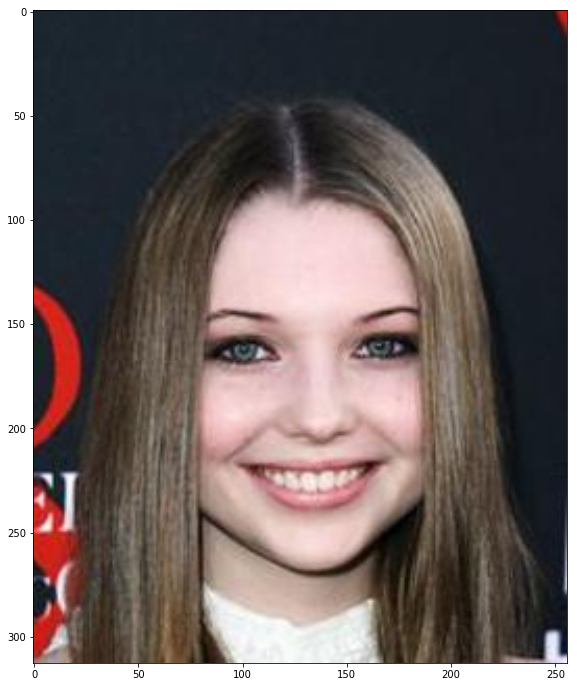

File path = celeb_mini\n00002187\n00002187_00000034.JPEG
Celeb Name: Sammi Hanratty


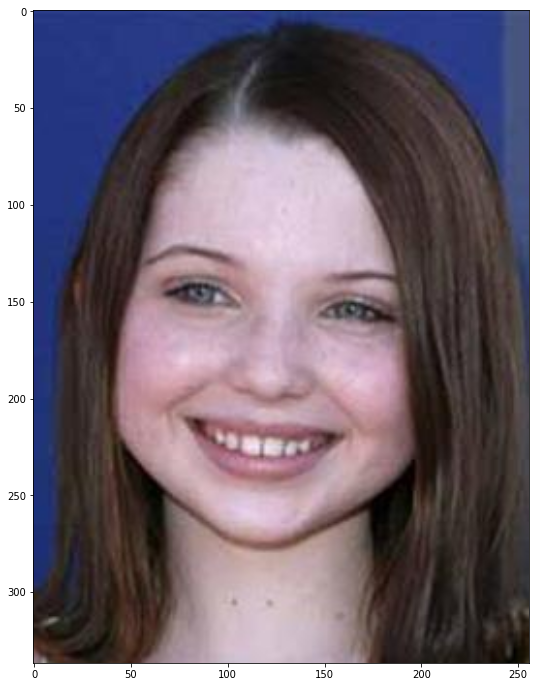

File path = celeb_mini\n00002187\n00002187_00000203.JPEG
Celeb Name: Sammi Hanratty


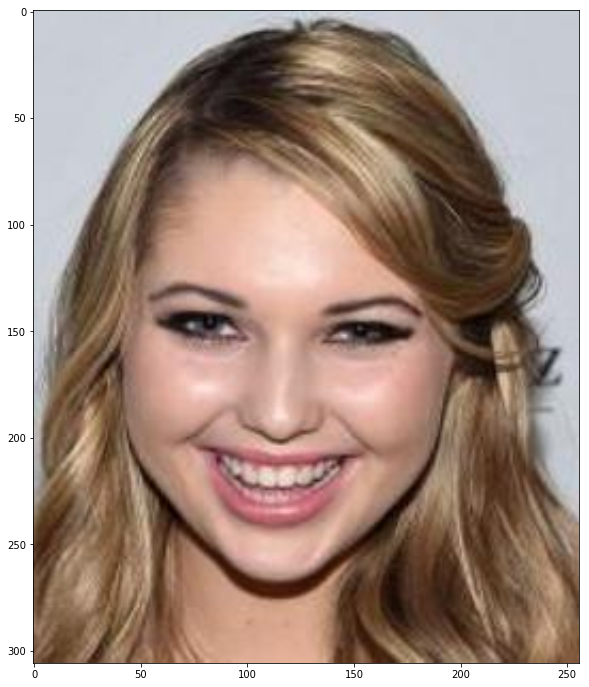

File path = celeb_mini\n00002187\n00002187_00000491.JPEG
Celeb Name: Sammi Hanratty


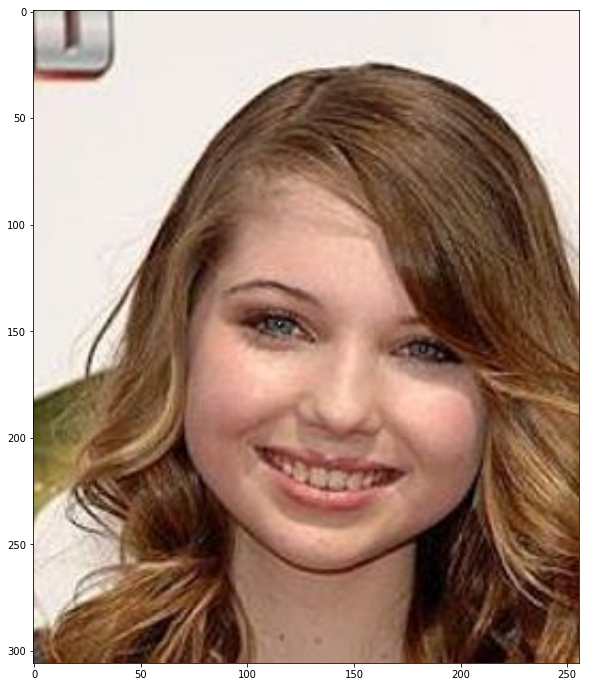

File path = celeb_mini\n00002187\n00002187_00000583.JPEG
Celeb Name: Sammi Hanratty


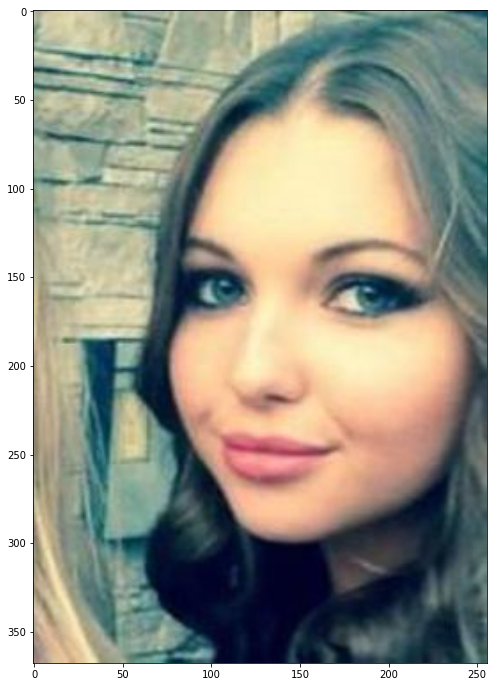

File path = celeb_mini\n00002187\n00002187_00000833.JPEG
Celeb Name: Sammi Hanratty


In [14]:
# Each subfolder has images of a particular celeb
subfolders = os.listdir(faceDatasetFolder)

# Let us choose a random folder and display all images
random_folder = random.choice(subfolders)

# Also find out the name of the celeb from the folder name and folder-> name mapping dictionary loaded earlier
celebname = labelMap[random_folder]

# Load all images in the subfolder
imagefiles = os.listdir(os.path.join(faceDatasetFolder, random_folder))

# Read each image and display along with the filename and celeb name
for file in imagefiles:
#     Get full path of each image file
    fullPath = os.path.join(faceDatasetFolder,random_folder,file)
    im = cv2.imread(fullPath)
    plt.imshow(im[:,:,::-1])
    plt.show()
#     Also print the filename and celeb name
    print("File path = {}".format(fullPath))
    print("Celeb Name: {}".format(celebname))

In [6]:
labelMap

{'n00000001': 'A.J. Buckley',
 'n00000002': 'A.R. Rahman',
 'n00000003': 'Aamir Khan',
 'n00000004': 'Aaron Staton',
 'n00000005': 'Aaron Tveit',
 'n00000006': 'Aaron Yoo',
 'n00000007': 'Abbie Cornish',
 'n00000008': 'Abel Ferrara',
 'n00000009': 'A P J Abdul Kalam',
 'n00000010': 'Abigail Breslin',
 'n00000011': 'Abigail Klein',
 'n00000012': 'Abigail Spencer',
 'n00000013': 'Abraham Benrubi',
 'n00000014': 'Adam Baldwin',
 'n00000015': 'Adam Beach',
 'n00000016': 'Adam Brody',
 'n00000017': 'Adam Buxton',
 'n00000018': 'Adam Copeland',
 'n00000019': 'Adam Driver',
 'n00000020': 'Adam G. Sevani',
 'n00000021': 'Adam Garcia',
 'n00000022': 'Adam Godley',
 'n00000023': 'Adam Goldberg',
 'n00000024': 'Adam Gregory',
 'n00000025': 'Adam Hicks',
 'n00000026': 'Adam Lambert',
 'n00000027': 'Adam Levine',
 'n00000028': 'Adam Rodriguez',
 'n00000029': 'Adelaide Clemens',
 'n00000030': 'Adelaide Kane',
 'n00000031': 'Adina Porter',
 'n00000032': 'Aditya Roy Kapoor',
 'n00000033': 'Adrian Gren

In [5]:
for k, v in labelMap.items():
    if(v == 'Selena Gomez'):
        print(k)

n00002239


## <font color="blue">TODO</font>
You have to write the code for enrollment and testing to get the desired output as shown in the intro section.

**You can take help from the code we had provided in week 4 material.**

## <font color="red">1. Enrollment of Celeb Images </font>
Process images one by and one. 

Convert image from RGB to BGR, because Dlib uses RGB as default format.

Detect faces in the image and compute a face descriptor for each image and save them in an array so that it can be used during testing.

In [25]:
subfolders = []
for x in os.listdir(faceDatasetFolder):
    xpath = os.path.join(faceDatasetFolder, x)
    if os.path.isdir(xpath):
        subfolders.append(xpath)

imagePaths = []
for i, subfolder in enumerate(subfolders):
    for x in os.listdir(subfolder):
        xpath = os.path.join(subfolder, x)
    if x.endswith('.JPEG'):
        imagePaths.append(xpath)


In [26]:
import re

In [27]:
#YOUR CODE HERE
# Process images one by one
# We will store face descriptors in an ndarray (faceDescriptors)
# and their corresponding labels in dictionary (index)


# read subfolders in folder "faces"
subfolders = []
for x in os.listdir(faceDatasetFolder):
    xpath = os.path.join(faceDatasetFolder, x)
    if os.path.isdir(xpath):
        subfolders.append(xpath)

imagePaths = []
for i, subfolder in enumerate(subfolders):
    for x in os.listdir(subfolder):
        xpath = os.path.join(subfolder, x)
    #if x.endswith('.JPEG'):
        imagePaths.append(xpath)

index = {}
i = 0
faceDescriptors = None
for imagePath in imagePaths:
    print("processing: {}".format(imagePath))
  # read image and convert it to RGB
    img = cv2.imread(imagePath)
  # detect faces in image
    faces = faceDetector(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    print("{} Face(s) found".format(len(faces)))
  # Now process each face we found
    for k, face in enumerate(faces):

        # Find facial landmarks for each detected face
        shape = shapePredictor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), face)

        # convert landmarks from Dlib's format to list of (x, y) points
        landmarks = [(p.x, p.y) for p in shape.parts()]

        # Compute face descriptor using neural network defined in Dlib.
        # It is a 128D vector that describes the face in img identified by shape.
        faceDescriptor = faceRecognizer.compute_face_descriptor(img, shape)

        # Convert face descriptor from Dlib's format to list, then a NumPy array
        faceDescriptorList = [x for x in faceDescriptor]
        faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
        faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]

        # Stack face descriptors (1x128) for each face in images, as rows
        if faceDescriptors is None:
            faceDescriptors = faceDescriptorNdarray
        else:
            faceDescriptors = np.concatenate((faceDescriptors, faceDescriptorNdarray), axis=0)

        # save the label for this face in index. We will use it later to identify
        # person name corresponding to face descriptors stored in NumPy Array
        folder_name = re.search("\\\\n(.+)\\\\",imagePath)
        folder = folder_name.group().split("\\",1)
        index_file = folder[1].split("\\",1)
        index[i] = labelMap[index_file[0]]
        i += 1

processing: celeb_mini\n00000102\n00000102_00000068.JPEG
1 Face(s) found
processing: celeb_mini\n00000102\n00000102_00000434.JPEG
1 Face(s) found
processing: celeb_mini\n00000102\n00000102_00000510.JPEG
1 Face(s) found
processing: celeb_mini\n00000102\n00000102_00000547.JPEG
1 Face(s) found
processing: celeb_mini\n00000102\n00000102_00000588.JPEG
1 Face(s) found
processing: celeb_mini\n00002239\n00002239_00000084.JPEG
1 Face(s) found
processing: celeb_mini\n00002239\n00002239_00000179.JPEG
1 Face(s) found
processing: celeb_mini\n00002239\n00002239_00000440.JPEG
1 Face(s) found
processing: celeb_mini\n00002239\n00002239_00000600.JPEG
1 Face(s) found
processing: celeb_mini\n00002239\n00002239_00000728.JPEG
1 Face(s) found


In [17]:
i = re.search('\n(.+)','celeb_mini\n00000001\n00000001_00000900.JPEG')

In [18]:
i.group()

'\n00000001'

In [28]:
import _pickle as cPickle
# Write descriors and index to disk
np.save('descriptors.npy', faceDescriptors)
# index has image paths in same order as descriptors in faceDescriptors
with open('index.pkl', 'wb') as f:
    cPickle.dump(index, f)

## <font color="red">2. Testing</font>
Once you have enrolled the celebs, you should be able to use them to find the closest celeb to the given test image using minimum distance rule.

You need to find the embeddings of the test images and compare it with the enrolled celebs to find the look-alike. 

Finally, display the celeb along side the input image. Partial code is given.

In [29]:
faceDescriptors

array([[-0.13441151,  0.11263459,  0.13305002, ...,  0.02028705,
         0.03071066,  0.05436534],
       [-0.08947445,  0.05761465,  0.08291157, ...,  0.01757174,
         0.00812772,  0.0475691 ],
       [-0.09240223,  0.07549787,  0.11834569, ..., -0.02501866,
         0.09997031,  0.05345724],
       ...,
       [-0.13712312,  0.01131021, -0.02181276, ...,  0.00540061,
         0.10104303, -0.01240611],
       [-0.0996756 , -0.01967994,  0.0232846 , ..., -0.02628704,
         0.07432979, -0.02029622],
       [-0.02233295,  0.05240143, -0.01596494, ...,  0.05018629,
        -0.0073992 , -0.01098347]])

In [21]:
matplotlib.rcParams['figure.figsize'] = (12.0,12.0)

[0.42035206 0.48123471 0.5308647  0.46279995 0.48180359 0.96454059
 0.89605639 1.01000633 0.99806023 0.93809812]


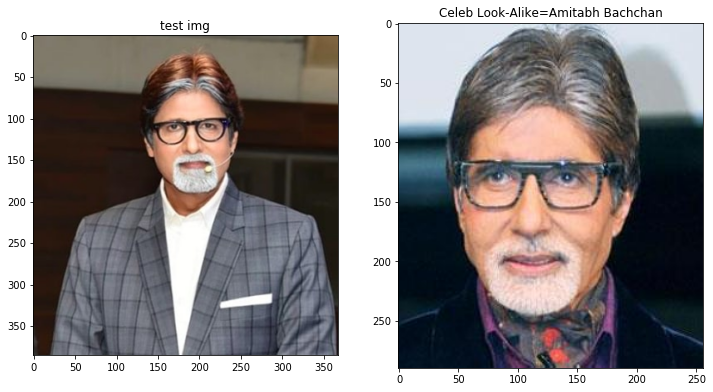

[0.85726905 0.8913784  0.87636574 0.84087195 0.90934611 0.6375985
 0.57129178 0.5906502  0.58041208 0.63382895]


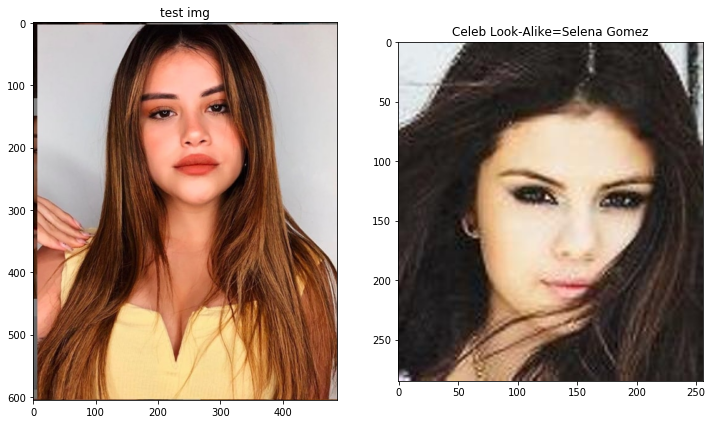

In [36]:
# load descriptors and index file generated during enrollment
index = np.load('index.pkl', allow_pickle=True)
faceDescriptorsEnrolled = np.load('descriptors.npy')

# read image
testImages = glob.glob('test-images/*.jpg')

for test in testImages:
    im = cv2.imread(test)
    imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    #####################
    #  YOUR CODE HERE
    faces = faceDetector(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    # Now process each face we found
    for face in faces:

        # Find facial landmarks for each detected face
        shape = shapePredictor(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), face)

        # find coordinates of face rectangle
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()

        # Compute face descriptor using neural network defined in Dlib
        # using facial landmark shape
        faceDescriptor = faceRecognizer.compute_face_descriptor(im, shape)

        # Convert face descriptor from Dlib's format to list, then a NumPy array
        faceDescriptorList = [m for m in faceDescriptor]
        faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
        faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]

        # Calculate Euclidean distances between face descriptor calculated on face dectected
        # in current frame with all the face descriptors we calculated while enrolling faces
        distances = np.linalg.norm(faceDescriptorsEnrolled - faceDescriptorNdarray, axis=1)
        # Calculate minimum distance and index of this face
        argmin = np.argmin(distances)  # index
        minDistance = distances[argmin]  # minimum distance
        print(distances)
        # Dlib specifies that in general, if two face descriptor vectors have a Euclidean
        # distance between them less than 0.6 then they are from the same
        # person, otherwise they are from different people.

        # This threshold will vary depending upon number of images enrolled
        # and various variations (illuminaton, camera quality) between
        # enrolled images and query image
        # We are using a threshold of 0.5

        # If minimum distance if less than threshold
        # find the name of person from index
        # else the person in query image is unknown
        if minDistance <= 0.6:
            label = index[argmin]
        else:
            label = 'unknown'
        celeb_name = label
        ####################

        plt.subplot(121)
        plt.imshow(imDlib)
        plt.title("test img")
        
        folder = ''
        #TODO - display celeb image which looks like the test image instead of the black image.
        for k, v in labelMap.items():
            if(v == celeb_name):
                counter = 1
                for i in range(len(imagePaths)):
                    if(imagePaths[i].find(k) != -1):
                        if(counter < 2):
                            celeb_dis = cv2.imread(imagePaths[i])
                            plt.subplot(122)
                            plt.imshow(celeb_dis[:,:,::-1])
                            plt.title("Celeb Look-Alike={}".format(celeb_name))
                            plt.show()
                            counter+=1

In [32]:
imagePaths

['celeb_mini\\n00000102\\n00000102_00000068.JPEG',
 'celeb_mini\\n00000102\\n00000102_00000434.JPEG',
 'celeb_mini\\n00000102\\n00000102_00000510.JPEG',
 'celeb_mini\\n00000102\\n00000102_00000547.JPEG',
 'celeb_mini\\n00000102\\n00000102_00000588.JPEG',
 'celeb_mini\\n00002239\\n00002239_00000084.JPEG',
 'celeb_mini\\n00002239\\n00002239_00000179.JPEG',
 'celeb_mini\\n00002239\\n00002239_00000440.JPEG',
 'celeb_mini\\n00002239\\n00002239_00000600.JPEG',
 'celeb_mini\\n00002239\\n00002239_00000728.JPEG']

# Code Explanation
## The purpose of this project is to leverage DLIB for Deep Learning based Face Recognition
## Dlib has facedetection, landmarks detection functionality which are designed using classical computer vision while face recognition model resnet is deep learning model trained on tons of images here we will be combining all the above tools

# DLIB's resnet face recognition model forms a cluster of similar looking datapoints while it is training

# The concept we will be using here is called Enrollment since the deep learning model is trained on millions of images what we have to do here is add another set of images of faces which model has not seen before and based on the newly added images for each image neural networks will convert that image into a vector of specific size, store it and then convert into datapoint which will be placed into the cluster of similar looking images where newly added image features are matching with the old trained image faces

### 1) Import all the necessary libraries
### 2) Download the required dataset images for testing and enrolling the faces
### 3) Initialize FaceDetection, Landmarks Detection and Face Recognition model
### 4) Load the data for the enrollment by locating the face directory and storing the mapping of images along with the corresponding labels
### 5) Compute face descriptor using facial landmarks. This is a 128 dimensional vector which represents a face. We will convert face descriptor from Dlib’s format to a NumPy array for ease of mathematical computations and read/write on disk. Process each image in the dataset and compute descriptors
### 6) Inference Detect faces in query image. For each face detect facial landmarks. Dlib specifies that in general, if two face descriptor vectors have a Euclidean distance between them less than 0.6 then they are from the same person, otherwise they are from different people.